### デバッグ用

In [1]:
import os, sys
sys.path.append(os.path.dirname(os.getcwd()))

### モジュールインポート

In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from ensemble_outlier_sample_detection import EnsembleOutlierSampleDetector
import matplotlib.pyplot as plt
import seaborn as sns

### 定数を定義

In [3]:
SEED = 334

### データセットをインポート
明らかにyの一部が変な値になっているデータセットを使用．  
引用元: https://github.com/hkaneko1985/ensemble_outlier_sample_detection

In [4]:
example_path = 'example_chache.csv'
df = pd.read_csv(example_path, index_col = 0)
X = df.iloc[:, 1:]
y = df.iloc[:, 0]
display(X.head(), y.head())

x1        x2        x3        x4        x5        x6  \
sample_1 -0.008829  0.020603  0.012806  0.022196  0.014404  0.000542   
sample_2  0.054267 -0.011827  0.024182  0.010591  0.043688  0.028225   
sample_3  0.007996  0.085998  0.083851  0.068907  0.046763  0.029664   
sample_4  0.007808  0.058072  0.071922  0.075210  0.070864  0.041052   
sample_5  0.025469  0.069069  0.039437  0.035413  0.026697  0.018137   

                x7        x8        x9       x10  
sample_1 -0.017258  0.035589  0.002711 -0.005959  
sample_2 -0.026693  0.002172  0.036835 -0.030305  
sample_3  0.023624  0.026716  0.005059  0.018760  
sample_4  0.031952  0.061823  0.032988 -0.028616  
sample_5  0.024466  0.064571  0.043171  0.033427

sample_1    4.862230
sample_2    4.979903
sample_3    5.068076
sample_4    5.166788
sample_5    5.374128
Name: y, dtype: float64

### pairplotで分布を視覚的に確認
yとその他の変数との相関をみると明らかに逸脱した集団が存在する．

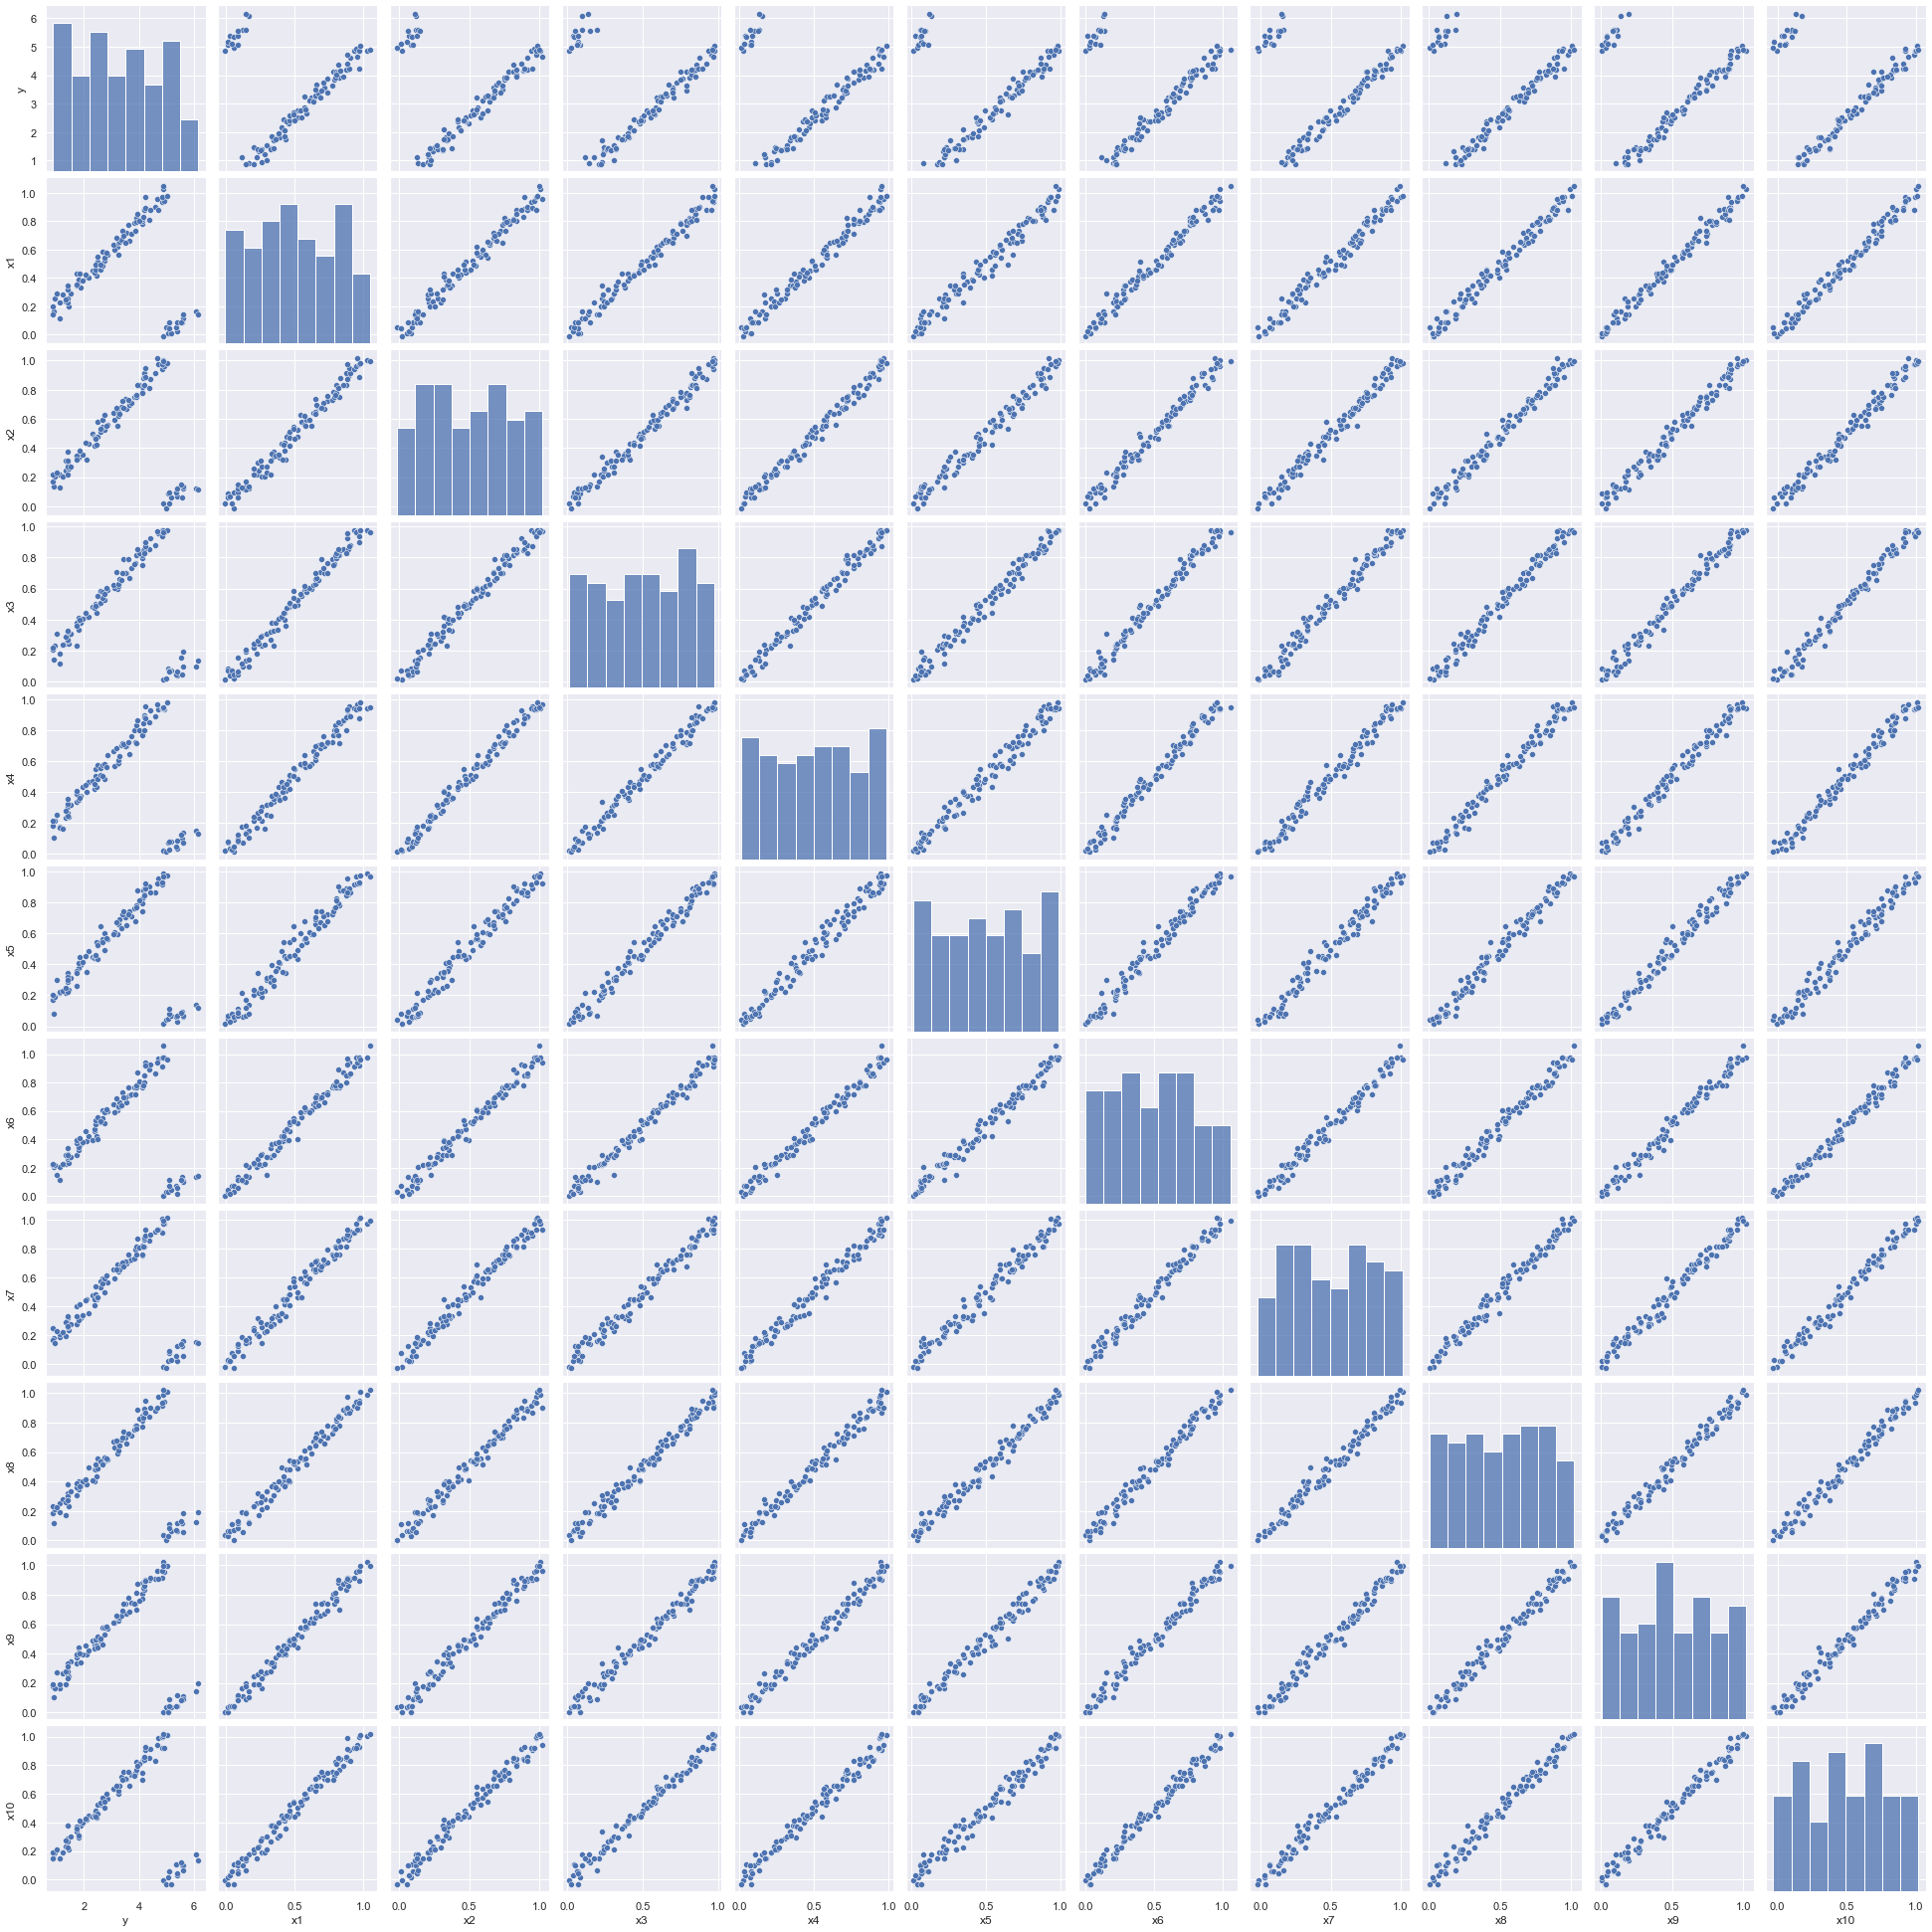

In [5]:
sns.set(style = 'darkgrid')
sns.pairplot(data = df)

### 使う機械学習モデルを事前に定義

In [6]:
rf = RandomForestRegressor(n_jobs = -1, random_state = SEED)

## 何も取り除かない場合
### 予測

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = SEED)
rf.fit(X_train, y_train)
y_pred_on_train = rf.predict(X_train)
y_pred_on_test = rf.predict(X_test)

print('train: {0:.3f}'.format(r2_score(y_train, y_pred_on_train)))
print('test: {0:.3f}'.format(r2_score(y_test, y_pred_on_test)))

train: 0.973
test: 0.659


### グラフにしてみる
外れサンプルのせいでうまく予測できない部分が出てくる．

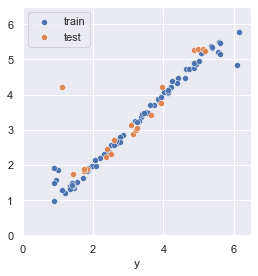

In [8]:
fig = plt.figure(facecolor = 'white')
ax = fig.add_subplot(111)

sns.set(style = 'darkgrid', palette = 'pastel')
sns.scatterplot(y_train, y_pred_on_train, ax = ax, label = 'train')
sns.scatterplot(y_test, y_pred_on_test, ax = ax, label = 'test')

ax.set_xlim(0, 6.5)
ax.set_ylim(0, 6.5)

ax.set_aspect('equal')
plt.tight_layout()

### ELOをしてみる

In [9]:
elo = EnsembleOutlierSampleDetector(random_state = SEED, n_jobs = -1, cv = 5, metric = 'rmse')
elo.fit(X, y)

[iter 2 / 30]: : 3200it [01:36, 33.00it/s]                       


### 抽出

In [10]:
X_normal = X[~elo.outlier_support_]
y_normal = y[~elo.outlier_support_]

### pairplotで分布を視覚的に確認してみる
外れサンプルがなくなっていることがわかる．

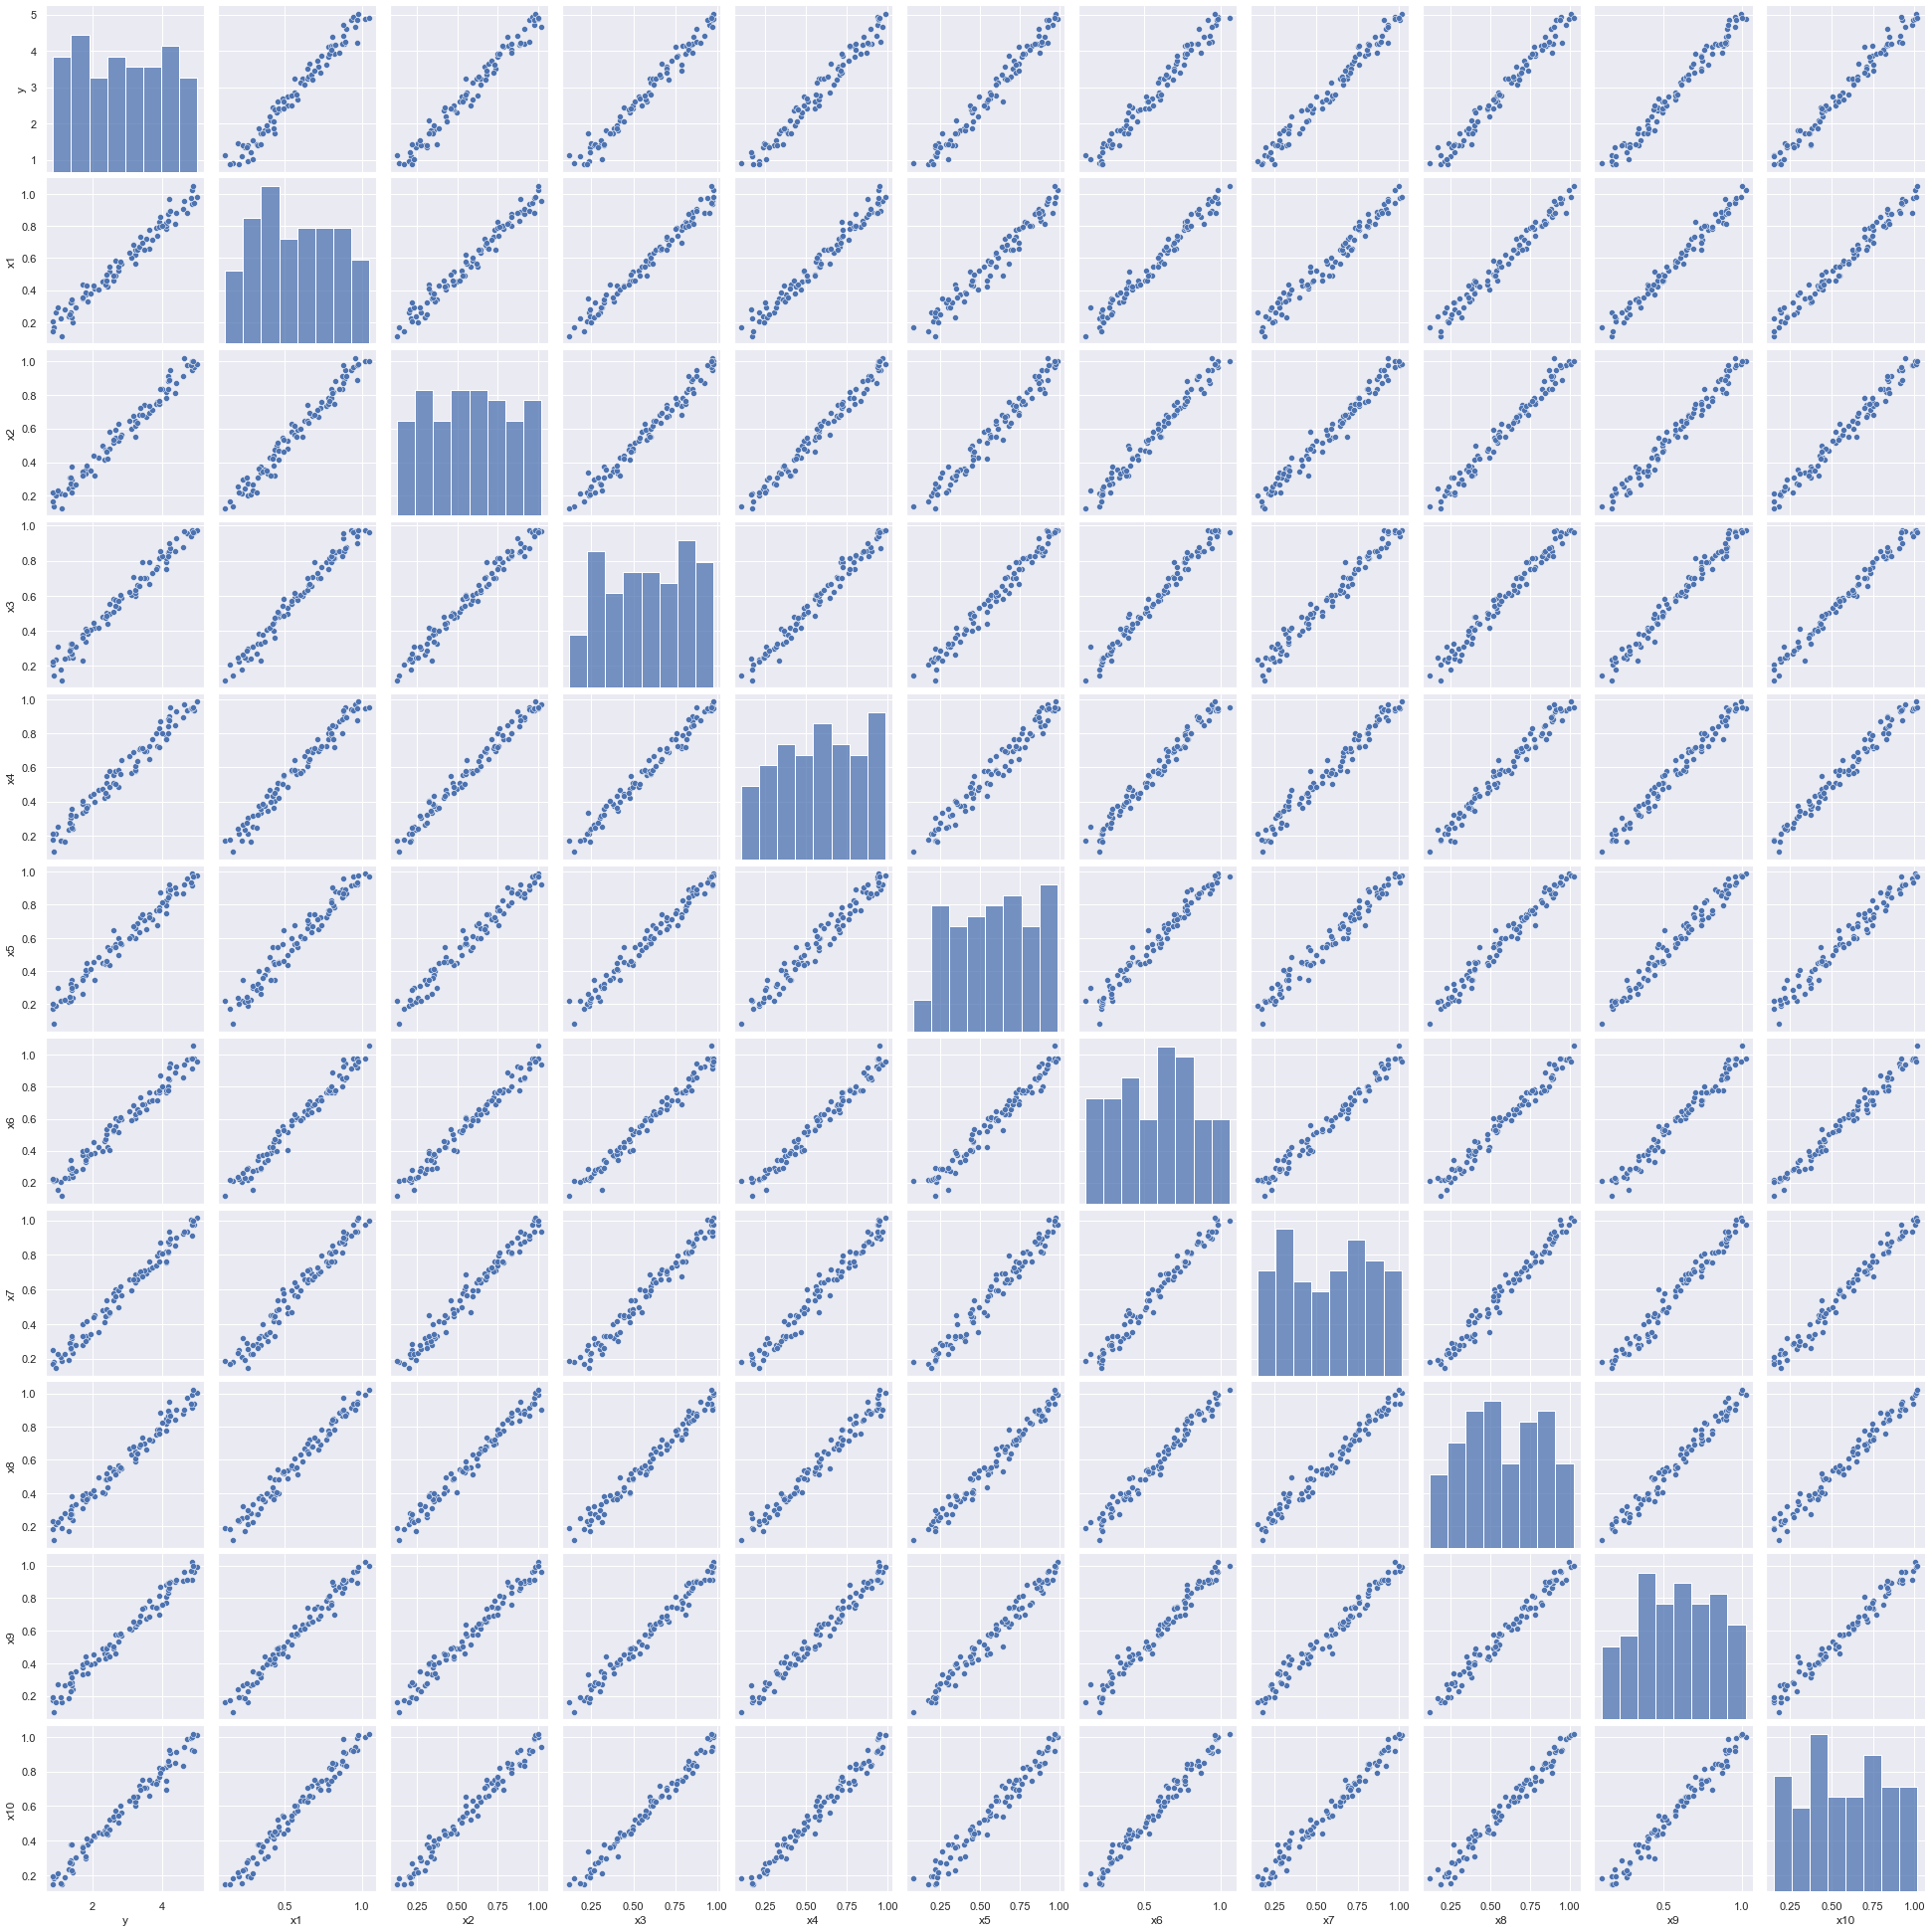

In [11]:
sns.set(style = 'darkgrid')
sns.pairplot(data = pd.concat([y_normal, X_normal], axis = 1))

### 予測してみる

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_normal, y_normal, test_size = 0.25)
rf.fit(X_train, y_train)
y_pred_on_train = rf.predict(X_train)
y_pred_on_test = rf.predict(X_test)

print('train: {0:.3f}'.format(r2_score(y_train, y_pred_on_train)))
print('test: {0:.3f}'.format(r2_score(y_test, y_pred_on_test)))

train: 0.997
test: 0.986


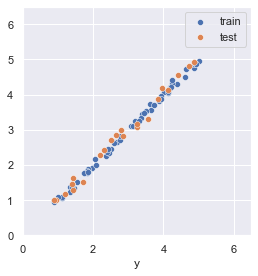

In [13]:
fig = plt.figure(facecolor = 'white')
ax = fig.add_subplot(111)

sns.set(style = 'darkgrid', palette = 'pastel')
sns.scatterplot(y_train, y_pred_on_train, ax = ax, label = 'train')
sns.scatterplot(y_test, y_pred_on_test, ax = ax, label = 'test')

ax.set_xlim(0, 6.5)
ax.set_ylim(0, 6.5)

ax.set_aspect('equal')
plt.tight_layout()